In [108]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [109]:
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from skompiler import skompile
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [110]:
pd.set_option("display.max_columns", None)
warnings.simplefilter(action="ignore", category=Warning)

In [111]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x) ## virgülden sonra üç basamak için
pd.set_option("display.width", 500)

In [112]:
df = pd.read_csv("DATA/satis_verileri_bisoft (1).csv")

In [113]:
df.head(10)

,Urun Kategorisi,Satis Miktari,Satis Tarihi,Bolge
0,Gida,223,10/10/2022,Istanbul
1,Aksesuar,723,6/16/2023,Ankara
2,Ev Esyalari,359,6/13/2023,Izmir
3,Aksesuar,698,12/1/2023,Izmir
4,Aksesuar,96,6/8/2022,Izmir
5,Giyim,964,3/16/2022,Eskisehir
6,Giyim,779,5/5/2022,Izmir
7,Gida,902,12/14/2021,Ankara
8,Gida,140,4/17/2024,Istanbul
9,Gida,866,3/5/2022,Istanbul


In [73]:
def outlier_threesholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [74]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threesholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [114]:
check_outlier(df, "Satis Miktari")

False

In [76]:
df.shape

(500, 4)

In [80]:
df.head(12)

,Urun Kategorisi,Satis Miktari,Satis Tarihi,Bolge
0,Gida,223,10/10/2022,Istanbul
1,Aksesuar,723,6/16/2023,Ankara
2,Ev Esyalari,359,6/13/2023,Izmir
3,Aksesuar,698,12/1/2023,Izmir
4,Aksesuar,96,6/8/2022,Izmir
5,Giyim,964,3/16/2022,Eskisehir
6,Giyim,779,5/5/2022,Izmir
7,Gida,902,12/14/2021,Ankara
8,Gida,140,4/17/2024,Istanbul
9,Gida,866,3/5/2022,Istanbul


In [81]:
# Tarih sütununu datetime formatına çeviririz
df['Satis Tarihi'] = pd.to_datetime(df['Satis Tarihi'])

In [82]:
# Veriyi tarih sırasına göre sıralarız
df.sort_values(by='Satis Tarihi', inplace=True)

In [83]:
# Tarih sütununu indeks olarak ayarlarız
df.set_index('Satis Tarihi', inplace=True)

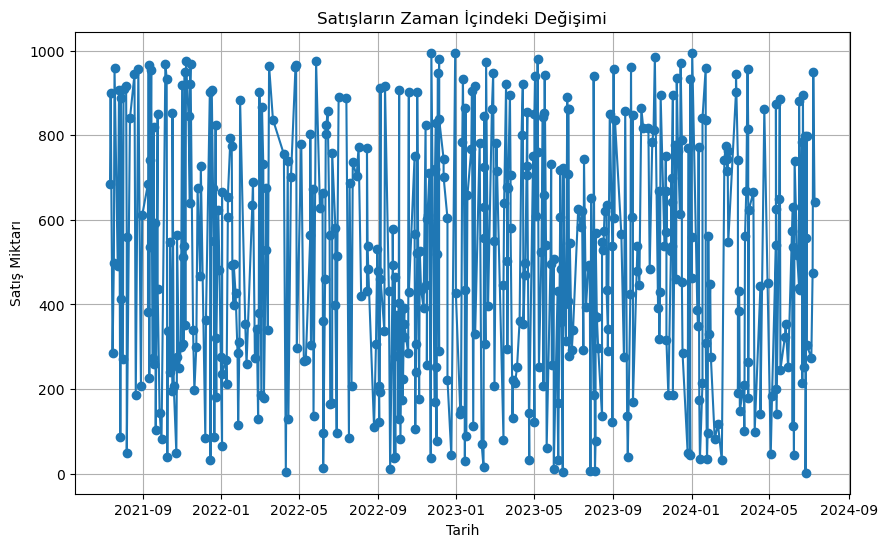

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Satis Miktari'], marker='o', linestyle='-')
plt.title('Satışların Zaman İçindeki Değişimi')
plt.xlabel('Tarih')
plt.ylabel('Satış Miktarı')
plt.grid(True)
plt.show()

In [85]:
result = adfuller(df['Satis Miktari'])

In [86]:
print('ADF İstatistiği:', result[0])

ADF İstatistiği: -22.865250946500005


In [87]:
print('p-değeri:', result[1])

p-değeri: 0.0


In [88]:
print('Kritik değerler:', result[4])

Kritik değerler: {'1%': -3.4435228622952065, '5%': -2.867349510566146, '10%': -2.569864247011056}


In [89]:
if result[1] <= 0.05:
    print('Zaman serisi durağan (stationary).')
else:
    print('Zaman serisi durağan değil (non-stationary).')

Zaman serisi durağan (stationary).


In [90]:
# Hareketli ortalama hesaplarız.
df['Hareketli Ortalama'] = df['Satis Miktari'].rolling(window=10).mean()

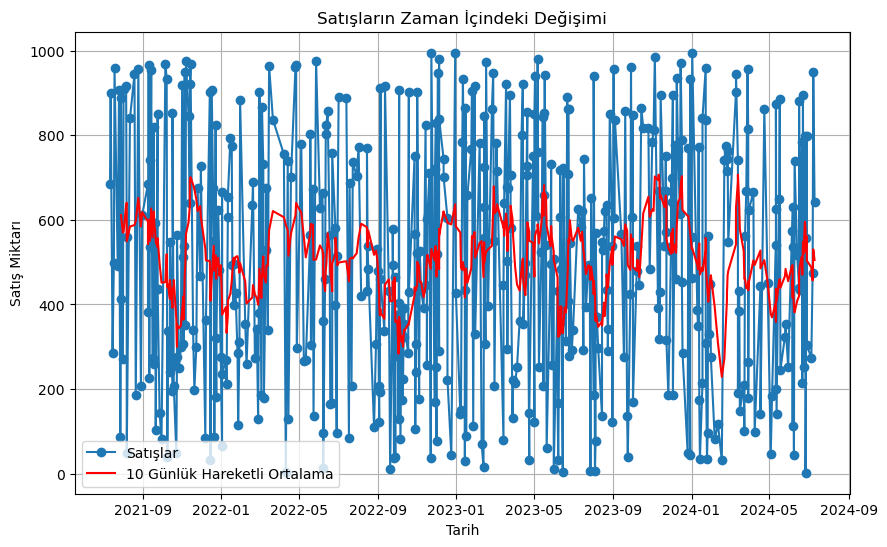

In [91]:
# Zaman serisi grafiği çizimi (hareketli ortalama ile)
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Satis Miktari'], marker='o', linestyle='-', label='Satışlar')
plt.plot(df.index, df['Hareketli Ortalama'], color='red', label='10 Günlük Hareketli Ortalama')
plt.title('Satışların Zaman İçindeki Değişimi')
plt.xlabel('Tarih')
plt.ylabel('Satış Miktarı')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
decomposition = seasonal_decompose(df['Satis Miktari'], model='additive', period=30)

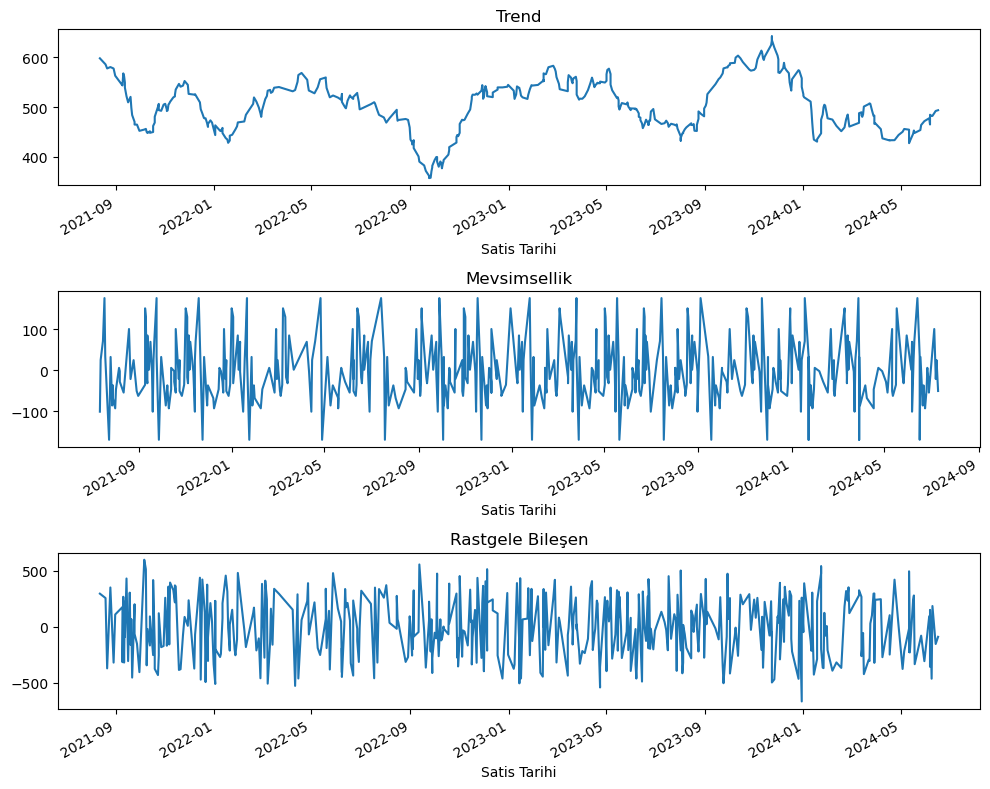

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1, title='Trend')
decomposition.seasonal.plot(ax=ax2, title='Mevsimsellik')
decomposition.resid.plot(ax=ax3, title='Rastgele Bileşen')
plt.tight_layout()
plt.show()

In [95]:
# Kategori bazında toplam satış miktarını hesaplama
kategori_satışları = df.groupby('Urun Kategorisi')['Satis Miktari'].sum().reset_index()

In [96]:
# Toplam satış miktarını büyükten küçüğe sıralama
en_çok_satan_kategori = kategori_satışları.sort_values(by='Satis Miktari', ascending=False).iloc[0]

In [97]:
print(f"En çok satan kategori: {en_çok_satan_kategori['Urun Kategorisi']}")

En çok satan kategori: Elektronik


In [98]:
print(f"Satış Miktarı: {en_çok_satan_kategori['Satis Miktari']}")

Satış Miktarı: 56375


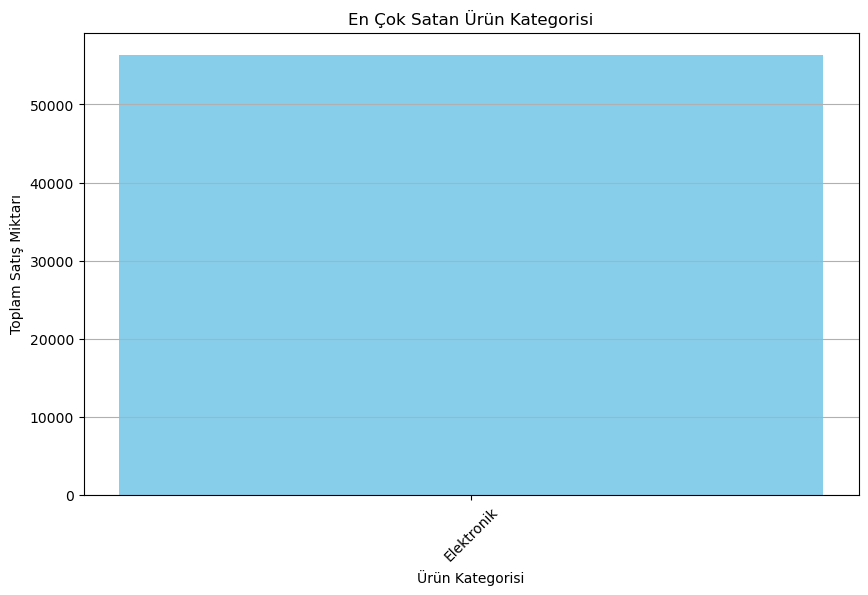

In [99]:
# En çok satan kategoriyi görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(en_çok_satan_kategori['Urun Kategorisi'], en_çok_satan_kategori['Satis Miktari'], color='skyblue')
plt.title('En Çok Satan Ürün Kategorisi')
plt.xlabel('Ürün Kategorisi')
plt.ylabel('Toplam Satış Miktarı')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [100]:
category_sales = df.groupby('Urun Kategorisi')['Satis Miktari'].sum().reset_index()

In [101]:
category_sales = category_sales.sort_values(by='Satis Miktari', ascending=False).reset_index(drop=True)

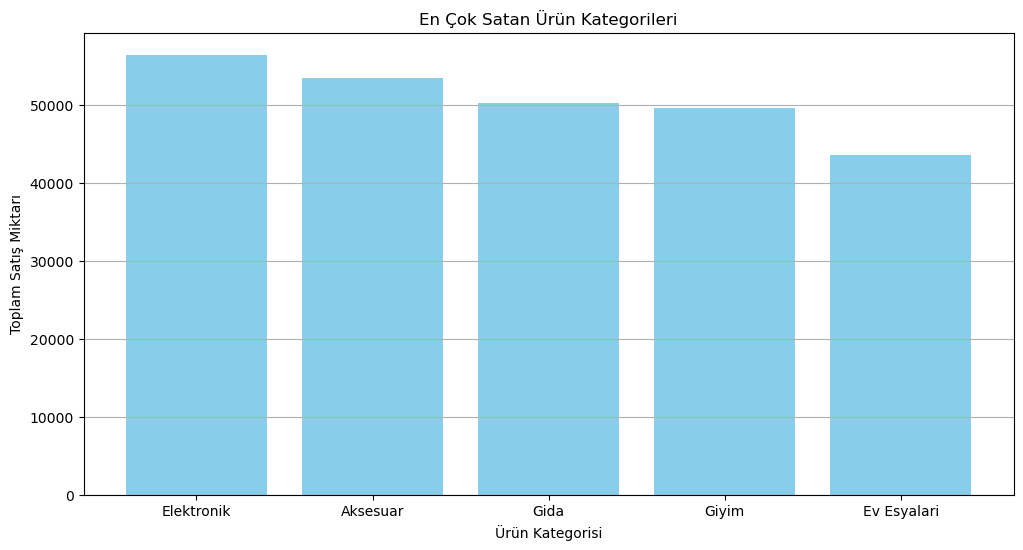

In [102]:
plt.figure(figsize=(12, 6))
plt.bar(category_sales['Urun Kategorisi'], category_sales['Satis Miktari'], color='skyblue')
plt.title('En Çok Satan Ürün Kategorileri')
plt.xlabel('Ürün Kategorisi')
plt.ylabel('Toplam Satış Miktarı')
plt.grid(axis='y')

In [103]:
# Bölge bazında toplam satış miktarını hesaplama
bölge_satışları = df.groupby('Bolge')['Satis Miktari'].sum().reset_index()

In [104]:
# Toplam satış miktarını büyükten küçüğe sıralama
bölge_satışları = bölge_satışları.sort_values(by='Satis Miktari', ascending=False)

In [105]:
print(bölge_satışları)

       Bolge  Satis Miktari
3      Izmir          70610
0     Ankara          63770
2   Istanbul          62897
1  Eskisehir          55833


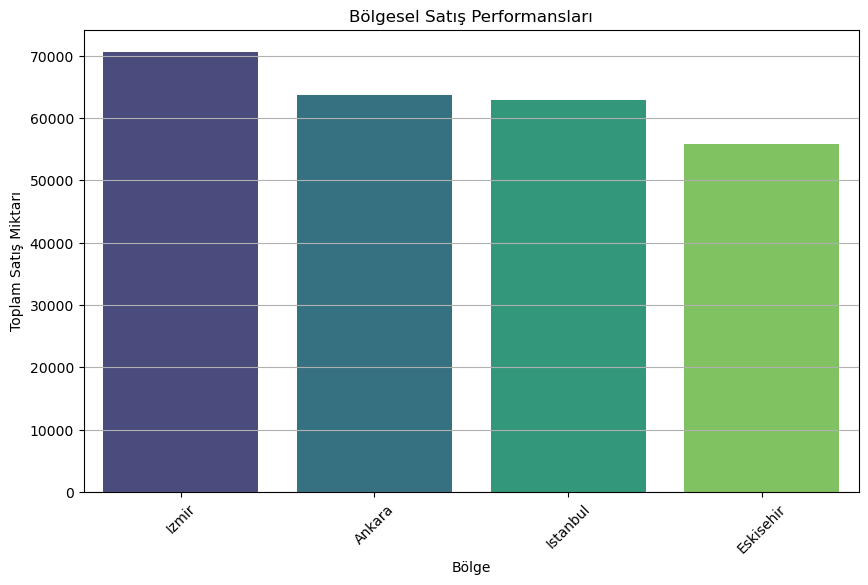

In [106]:
# Bölgesel satış performanslarını görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x='Bolge', y='Satis Miktari', data=bölge_satışları, palette='viridis')
plt.title('Bölgesel Satış Performansları')
plt.xlabel('Bölge')
plt.ylabel('Toplam Satış Miktarı')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [115]:
# Bölge ve kategori bazında toplam satış miktarını hesaplama
bölge_kategori_satışları = df.groupby(['Bolge', 'Urun Kategorisi'])['Satis Miktari'].sum().reset_index()

In [116]:
print(bölge_kategori_satışları)

        Bolge Urun Kategorisi  Satis Miktari
0      Ankara        Aksesuar          16404
1      Ankara      Elektronik          14204
2      Ankara     Ev Esyalari          14604
3      Ankara            Gida           6316
4      Ankara           Giyim          12242
5   Eskisehir        Aksesuar          12335
6   Eskisehir      Elektronik          12022
7   Eskisehir     Ev Esyalari           6938
8   Eskisehir            Gida          12103
9   Eskisehir           Giyim          12435
10   Istanbul        Aksesuar           7492
11   Istanbul      Elektronik          12396
12   Istanbul     Ev Esyalari          10335
13   Istanbul            Gida          18698
14   Istanbul           Giyim          13976
15      Izmir        Aksesuar          17176
16      Izmir      Elektronik          17753
17      Izmir     Ev Esyalari          11709
18      Izmir            Gida          13050
19      Izmir           Giyim          10922


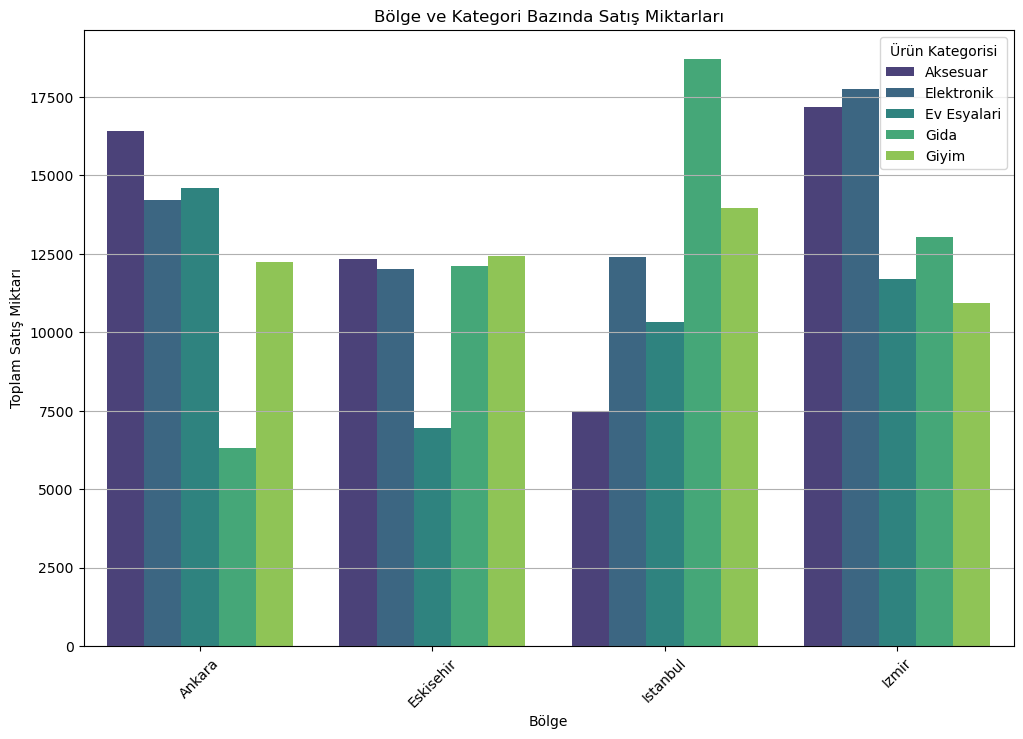

In [117]:
# Bölge ve kategori bazında satış miktarlarını görselleştirme
plt.figure(figsize=(12, 8))
sns.barplot(x='Bolge', y='Satis Miktari', hue='Urun Kategorisi', data=bölge_kategori_satışları, palette='viridis')
plt.title('Bölge ve Kategori Bazında Satış Miktarları')
plt.xlabel('Bölge')
plt.ylabel('Toplam Satış Miktarı')
plt.xticks(rotation=45)
plt.legend(title='Ürün Kategorisi')
plt.grid(axis='y')
plt.show()